In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

## Load and Preprocess the Data

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Load CIFAR-10 dataset
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

100%|██████████| 170498071/170498071 [00:04<00:00, 41493457.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


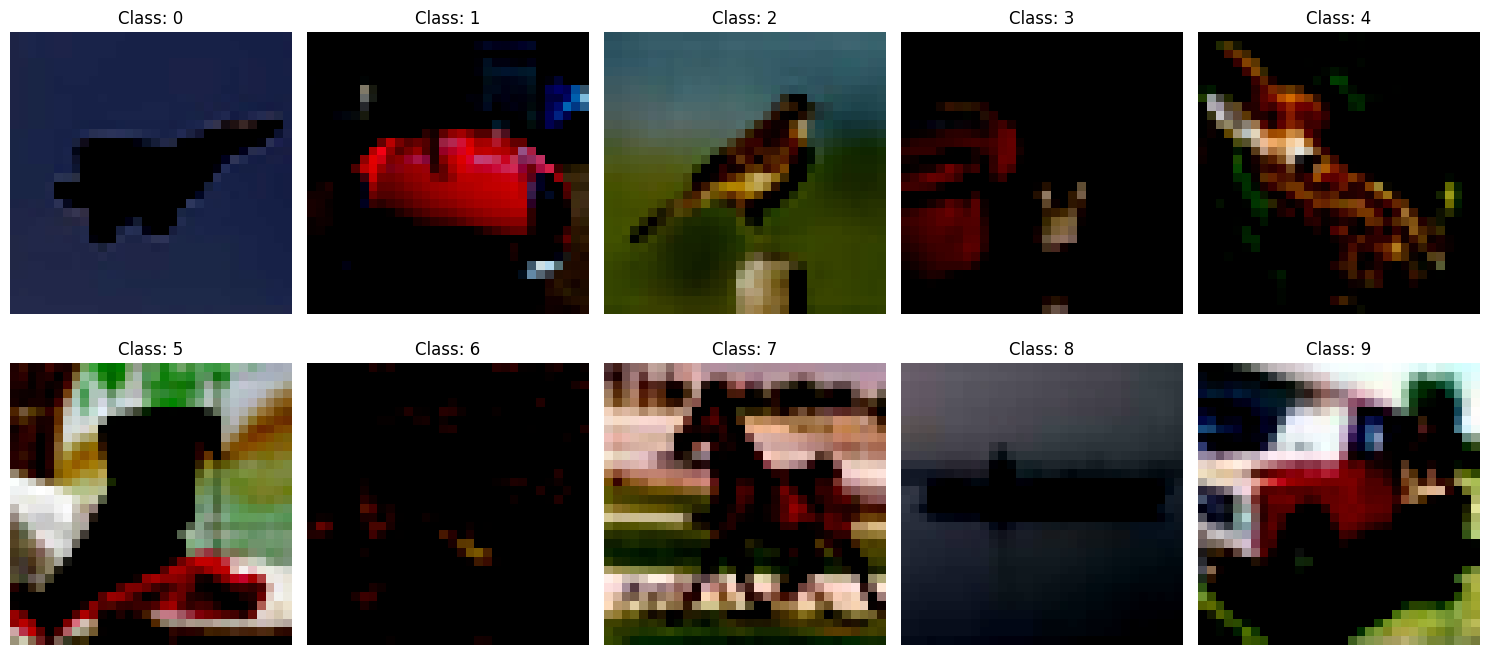

In [4]:
class_indices = {class_idx: [] for class_idx in range(10)}

# Iterate over the dataset to find indices of images for each class
for idx, (image, label) in enumerate(train_set):
    class_indices[label].append(idx)

# Load one image for each class and display
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()

for class_idx, ax in enumerate(axes):
    # Load the first image for each class
    image, label = train_set[class_indices[class_idx][0]]

    # Unnormalize the image
    image = image.permute(1, 2, 0)  # Channels last
    image = image.numpy()

    # Display the image
    ax.imshow(image)
    ax.set_title(f'Class: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

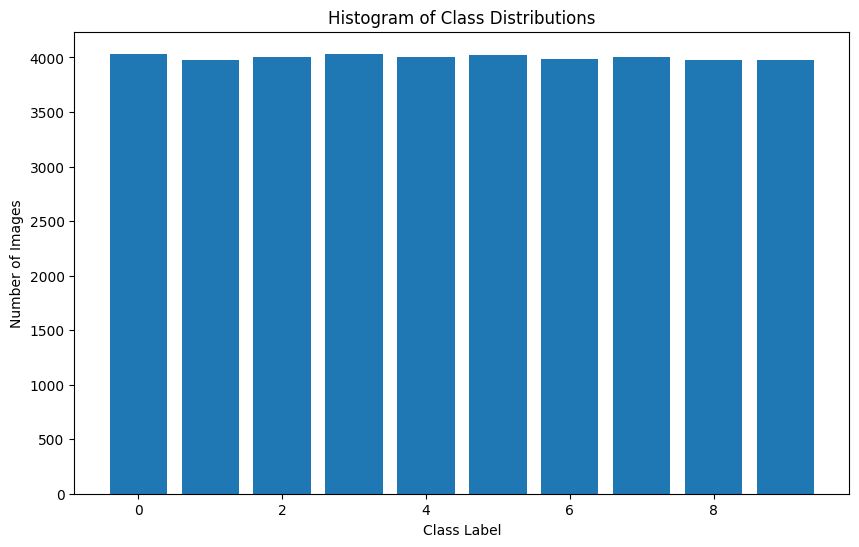

In [5]:
class_labels, class_counts = zip(*[(label, len(indices)) for label, indices in class_indices.items()])
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Histogram of Class Distributions')
plt.show()

In [6]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

## Define the ResNet Model

In [7]:
# Define the ResNet model
model = resnet18(pretrained=False).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
num_epochs = 10

## Investigate the Role of Mini-Batch Size on Overfitting

In [ ]:
batch_sizes = [32, 64, 128]
val_accuracies = {batch_size: [] for batch_size in batch_sizes}
train_losses = {batch_size: [] for batch_size in batch_sizes}
train_accuracies = {batch_size: [] for batch_size in batch_sizes}

for batch_size in batch_sizes:
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Accumulate running loss
            running_loss += loss.item()

        # Compute training accuracy and loss per epoch
        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)
        train_accuracies[batch_size].append(train_accuracy)
        train_losses[batch_size].append(train_loss)

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val
        val_accuracies[batch_size].append(val_accuracy)

        print(f'Batch size: {batch_size}, Epoch: {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Batch size: 32, Epoch: 1/10, Training Loss: 1.6925, Training Accuracy: 41.30%, Validation Accuracy: 49.66%
Batch size: 32, Epoch: 2/10, Training Loss: 1.2654, Training Accuracy: 54.74%, Validation Accuracy: 57.69%
Batch size: 32, Epoch: 3/10, Training Loss: 1.0621, Training Accuracy: 62.25%, Validation Accuracy: 61.20%
Batch size: 32, Epoch: 4/10, Training Loss: 0.9051, Training Accuracy: 68.05%, Validation Accuracy: 64.34%
Batch size: 32, Epoch: 5/10, Training Loss: 0.7693, Training Accuracy: 72.98%, Validation Accuracy: 65.24%
Batch size: 32, Epoch: 6/10, Training Loss: 0.6646, Training Accuracy: 76.48%, Validation Accuracy: 64.31%
Batch size: 32, Epoch: 7/10, Training Loss: 0.5590, Training Accuracy: 80.09%, Validation Accuracy: 66.37%
Batch size: 32, Epoch: 8/10, Training Loss: 0.4632, Training Accuracy: 83.44%, Validation Accuracy: 66.78%
Batch size: 32, Epoch: 9/10, Training Loss: 0.3891, Training Accuracy: 86.38%, Validation Accuracy: 66.93%
Batch size: 32, Epoch: 10/10, Trainin

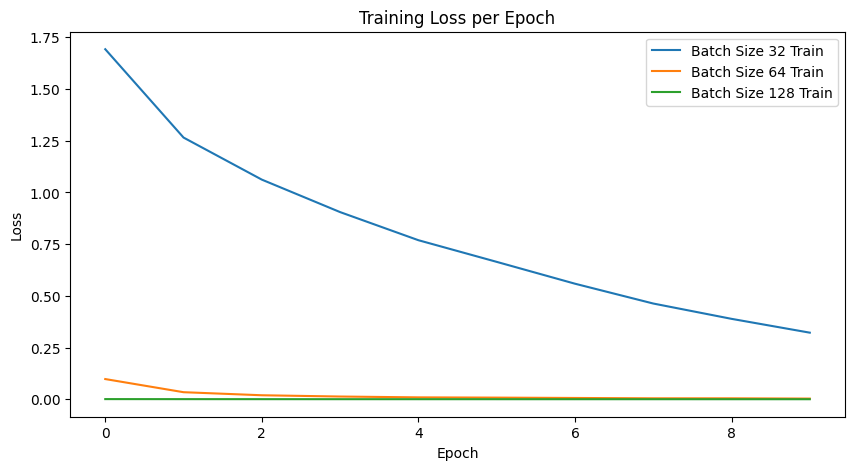

In [ ]:
# Plot training and validation loss per epoch for all batch sizes
plt.figure(figsize=(10, 5))
for batch_size in batch_sizes:
    plt.plot(train_losses[batch_size], label=f'Batch Size {batch_size} Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

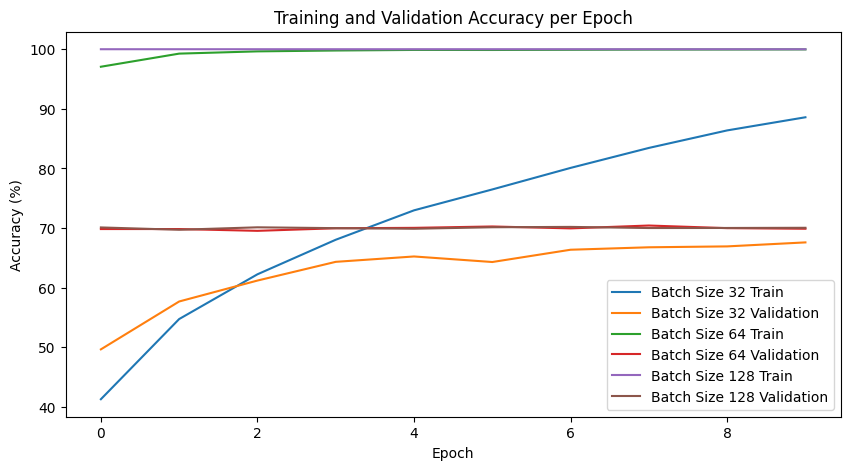

In [ ]:
# Plot training and validation accuracy per epoch for all batch sizes
plt.figure(figsize=(10, 5))
for batch_size in batch_sizes:
    plt.plot(train_accuracies[batch_size], label=f'Batch Size {batch_size} Train')
    plt.plot(val_accuracies[batch_size], label=f'Batch Size {batch_size} Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

## Measure the Amount of Gradient "Noise" Added by Mini-Batch SGD

In [ ]:
# Measure the amount of gradient "noise" added by mini-batch SGD
def measure_gradient_noise(model, train_loader, batch_size, num_batches):
    gradient_norms = []
    for i, (images, labels) in enumerate(train_loader):
        if i >= num_batches:
            break

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Compute the gradient norm
        grad_norm = 0
        for param in model.parameters():
            grad_norm += torch.norm(param.grad).item()
        gradient_norms.append(grad_norm)

    return np.mean(gradient_norms), np.std(gradient_norms)

In [ ]:
num_batches = 100
batch_size = 64
mean_noise, std_noise = measure_gradient_noise(model, train_loader, batch_size, num_batches)
print(f'Mean gradient noise: {mean_noise:.4f}, Standard deviation of gradient noise: {std_noise:.4f}')

Mean gradient noise: 0.1048, Standard deviation of gradient noise: 0.0328


## Compare the Effects of Adding Gaussian Noise to the Gradients Versus Varying the Mini-Batch Size

In [ ]:
std_deviations = [0, 0.5, 1.0]
val_accuracies = []
for std_dev in std_deviations:
    model = resnet18(pretrained=False).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        # Train the model
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            # Add Gaussian noise to the gradients
            for param in model.parameters():
                param.grad.data.add_(torch.randn(param.grad.size(), device=device) * std_dev)
                # param.grad.data.add_(torch.randn(param.grad.size()) * std_dev)

            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    print(f'Gaussian noise std. dev.: {std_dev:.2f}, Validation Accuracy: {val_accuracy:.2f}%')

Gaussian noise std. dev.: 0.00, Validation Accuracy: 57.12%
Gaussian noise std. dev.: 0.50, Validation Accuracy: 26.87%
Gaussian noise std. dev.: 1.00, Validation Accuracy: 18.16%


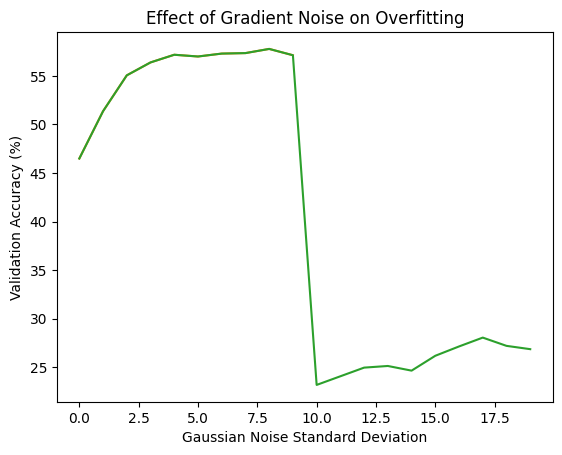

In [ ]:
plt.figure()
for i in range(3):
  plt.plot(val_accuracies[:10*i], label = f"{std_deviations[i]}")
plt.xlabel('Gaussian Noise Standard Deviation')
plt.ylabel('Validation Accuracy (%)')
plt.title('Effect of Gradient Noise on Overfitting')
plt.show()

\## Study the Interplay Between Step Size and Mini-Batch Size

In [10]:
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]
val_accuracies = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        model = resnet18(pretrained=False).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        scheduler = StepLR(optimizer, step_size=5, gamma=0.1) # Sheduler

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        for epoch in range(num_epochs):
            # Train the model
            model.train()
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Evaluate on the validation set
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)

        print(f'Batch size: {batch_size}, Learning rate: {lr:.3f}, Validation Accuracy: {val_accuracy:.2f}%')

Batch size: 32, Learning rate: 0.001, Validation Accuracy: 66.62%
Batch size: 32, Learning rate: 0.010, Validation Accuracy: 72.36%
Batch size: 32, Learning rate: 0.100, Validation Accuracy: 67.90%
Batch size: 64, Learning rate: 0.001, Validation Accuracy: 62.55%
Batch size: 64, Learning rate: 0.010, Validation Accuracy: 71.50%
Batch size: 64, Learning rate: 0.100, Validation Accuracy: 70.76%
Batch size: 128, Learning rate: 0.001, Validation Accuracy: 57.58%
Batch size: 128, Learning rate: 0.010, Validation Accuracy: 67.70%
Batch size: 128, Learning rate: 0.100, Validation Accuracy: 71.06%


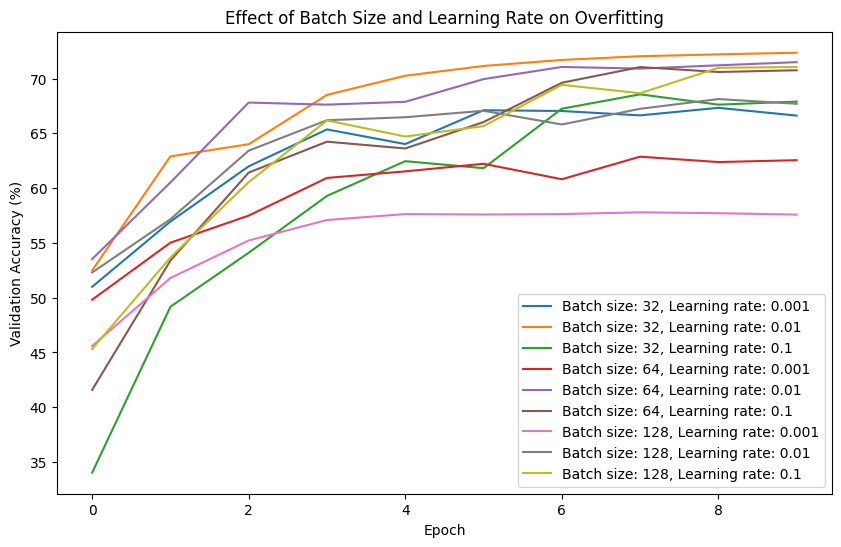

In [11]:
# Reshape val_accuracies into a 2D array
val_accuracies_2d = np.array(val_accuracies).reshape(len(batch_sizes), len(learning_rates), -1)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each batch size separately
for i, batch_size in enumerate(batch_sizes):
    for j, lr in enumerate(learning_rates):
        ax.plot(range(num_epochs), val_accuracies_2d[i, j], label=f'Batch size: {batch_size}, Learning rate: {lr}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Effect of Batch Size and Learning Rate on Overfitting')
ax.legend()
plt.show()

## Investigate the Use of Adaptive Approaches Like Adam and Their Impact on Overfitting

In [12]:
batch_sizes = [32, 64, 128]
val_accuracies_adam = {}

for batch_size in batch_sizes:
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = resnet18(pretrained=False).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    val_accuracies_adam[batch_size] = []

    for epoch in range(num_epochs):
        # Train the model
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_accuracies_adam[batch_size].append(val_accuracy)
        print(f'Batch Size: {batch_size}, Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%')

Batch Size: 32, Epoch [1/10], Validation Accuracy: 56.44%
Batch Size: 32, Epoch [2/10], Validation Accuracy: 65.47%
Batch Size: 32, Epoch [3/10], Validation Accuracy: 71.03%
Batch Size: 32, Epoch [4/10], Validation Accuracy: 70.82%
Batch Size: 32, Epoch [5/10], Validation Accuracy: 74.17%
Batch Size: 32, Epoch [6/10], Validation Accuracy: 74.81%
Batch Size: 32, Epoch [7/10], Validation Accuracy: 75.22%
Batch Size: 32, Epoch [8/10], Validation Accuracy: 75.54%
Batch Size: 32, Epoch [9/10], Validation Accuracy: 75.92%
Batch Size: 32, Epoch [10/10], Validation Accuracy: 75.37%
Batch Size: 64, Epoch [1/10], Validation Accuracy: 57.38%
Batch Size: 64, Epoch [2/10], Validation Accuracy: 63.75%
Batch Size: 64, Epoch [3/10], Validation Accuracy: 68.51%
Batch Size: 64, Epoch [4/10], Validation Accuracy: 71.98%
Batch Size: 64, Epoch [5/10], Validation Accuracy: 73.03%
Batch Size: 64, Epoch [6/10], Validation Accuracy: 73.87%
Batch Size: 64, Epoch [7/10], Validation Accuracy: 74.63%
Batch Size: 6

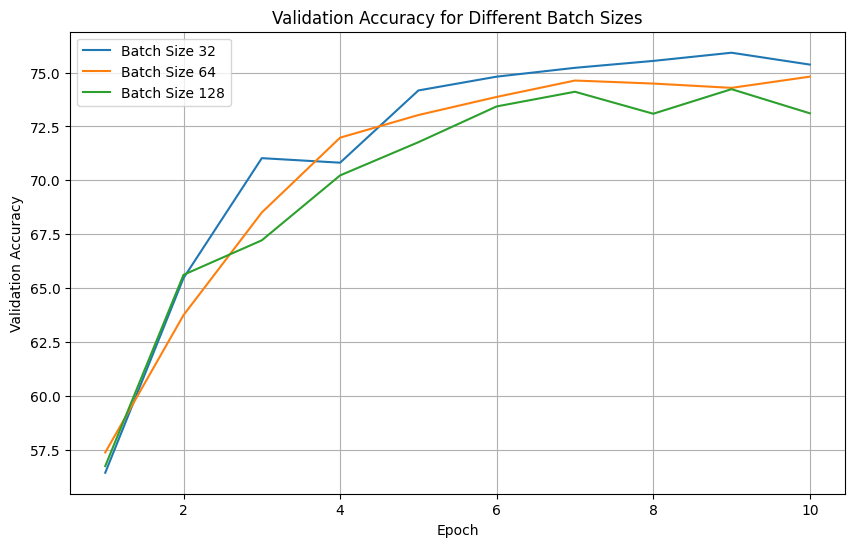

In [13]:
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    plt.plot(range(1, num_epochs + 1), val_accuracies_adam[batch_size], label=f'Batch Size {batch_size}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the Final Model on the Test Set

In [14]:
# Evaluate on the test set
# batch size - 128
# lr - dynamic

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 72.79%
